In [3]:
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
import pickle

from SSD.ssd_v2 import SSD300v2
from SSD.ssd_training import MultiboxLoss
from SSD.ssd_utils import BBoxUtility

from keras.preprocessing import image
from scipy.misc import imread
from keras.applications.imagenet_utils import preprocess_input
import numpy as np


from get_data_from_XML import XML_preprocessor
from generator import Generator

voc_classes = ['Aeroplane', 'Bicycle', 'Bird', 'Boat', 'Bottle',
               'Bus', 'Car', 'Cat', 'Chair', 'Cow', 'Diningtable',
               'Dog', 'Horse','Motorbike', 'Person', 'Pottedplant',
               'Sheep', 'Sofa', 'Train', 'Tvmonitor']
NUM_CLASSES = len(voc_classes) + 1
input_shape = (300, 300, 3)

model = SSD300v2(input_shape, num_classes=NUM_CLASSES)

loss = MultiboxLoss(NUM_CLASSES, neg_pos_ratio=2.0).compute_loss
model.compile(optimizer='Adadelta', loss=loss)

priors = pickle.load(open('./SSD300/prior_boxes_ssd300.pkl', 'rb'))
bbox_util = BBoxUtility(NUM_CLASSES, priors)



#model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, 300, 300, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
conv1_2 (Conv2D)                (None, 300, 300, 64) 36928       conv1_1[0][0]                    
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 150, 150, 64) 0           conv1_2[0][0]                    
__________________________________________________________________________________________________
conv2_1 (C

In [6]:
pascal_voc_07_parser = XML_preprocessor(data_path='./VOCdevkit/VOC2010/Annotations/')


keys = list(pascal_voc_07_parser.data.keys())
train_num = int(0.7 * len(keys))
train_keys = keys[:train_num]
val_keys = keys[train_num:]

gen = Generator(gt=pascal_voc_07_parser.data, bbox_util=bbox_util,
                 batch_size=16, path_prefix='./VOCdevkit/VOC2010/JPEGImages/',
                 train_keys=train_keys, val_keys=val_keys, image_size=(300, 300))

model.load_weights('./SSD.hdf5', by_name=True)

In [15]:
files = ('2007_008547.jpg','2007_008051.jpg', '2007_000033.jpg','2007_001763.jpg','2007_004830.jpg','2007_006585.jpg','2007_008415.jpg','2007_000799.jpg')

inputs = []
images = []
for f in files:
    f = "./pics/{}".format(f)
    img = image.load_img(""+f, target_size=(300, 300))
    img = image.img_to_array(img)
    
    images.append(imread(f))
    inputs.append(img.copy())

inputs = preprocess_input(np.array(inputs))

preds = model.predict(inputs, batch_size=1, verbose=1)
# preds.shape (5, 7308, 33)

results = bbox_util.detection_out(preds)
# type(results): list, len(results): 5, len(result[0]): 200, results[0].shape: (200, 6)

8/8 [==============================] - 25s 3s/step


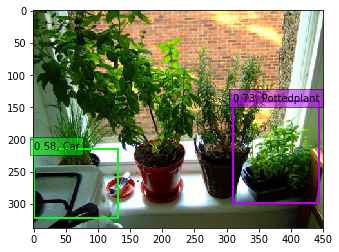

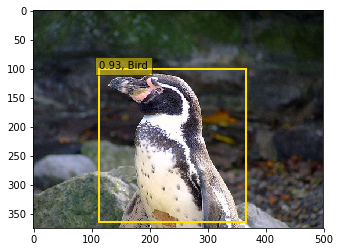

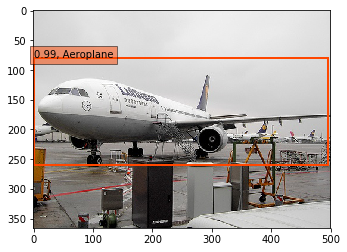

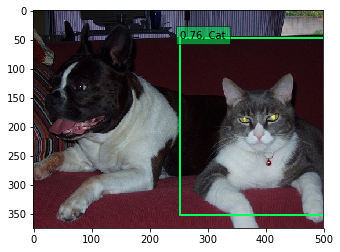

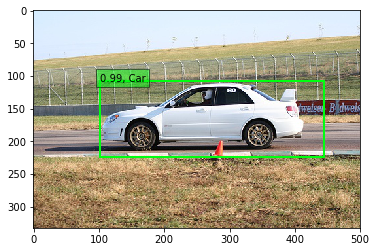

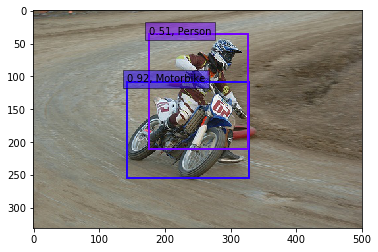

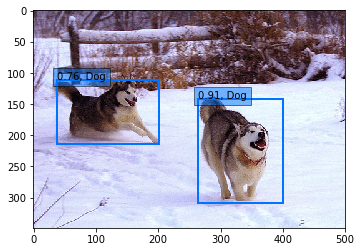

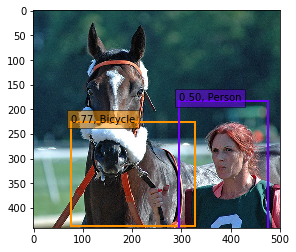

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

for i, img in enumerate(images):
    # Parse the outputs.
    det_label = results[i][:, 0]
    det_conf = results[i][:, 1]
    det_xmin = results[i][:, 2]
    det_ymin = results[i][:, 3]
    det_xmax = results[i][:, 4]
    det_ymax = results[i][:, 5]

    # Get detections with confidence higher than 0.6.
    top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.5]

    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]

    colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()

    plt.imshow(img / 255.)
    currentAxis = plt.gca()

    for i in range(top_conf.shape[0]):
        xmin = int(round(top_xmin[i] * img.shape[1]))
        ymin = int(round(top_ymin[i] * img.shape[0]))
        xmax = int(round(top_xmax[i] * img.shape[1]))
        ymax = int(round(top_ymax[i] * img.shape[0]))
        score = top_conf[i]
        label = int(top_label_indices[i])
        label_name = voc_classes[label - 1]
        display_txt = '{:0.2f}, {}'.format(score, label_name)
        coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
        color = colors[label]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})
    
    plt.show()